#### Chain Using LangGraph
we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

##### a) How to use chat messages as our graph state

In [3]:
#Import the env variables
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

##### Messages
We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.
Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)

In [5]:
from langchain_core.messages import HumanMessage,AIMessage
from pprint import pprint

messages = [AIMessage(content="Please tell me how may I help you?",name="LLM")]
messages.append(HumanMessage(content="I Wanted to learn about LangGraph",name="suresh"))
messages.append(AIMessage(content="Great Choice! LangGraph is a framework to build LLM applications using components.",name="LLM"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLM

Please tell me how may I help you?
================================ Human Message =================================
Name: suresh

I Wanted to learn about LangGraph
================================== Ai Message ==================================
Name: LLM

Great Choice! LangGraph is a framework to build LLM applications using components.


##### We can give this messages as input to the chat models

In [7]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant")
response = llm.invoke(messages)
response

AIMessage(content=" \n\nLangGraph is a Python-based framework created by the Meta AI research team to build conversational AI systems and other NLP applications. It's a modular and flexible framework that allows developers to easily build, train, and deploy large language models (LLMs).\n\nKey Features of LangGraph:\n\n1. **Modular Architecture**: LangGraph consists of several components, each responsible for a specific task, such as data loading, model training, and inference. This modular design makes it easy to swap out components and customize the framework to suit your needs.\n2. **Support for Multiple Models**: LangGraph supports various LLM architectures, including transformer-based models like BERT and RoBERTa. This allows developers to leverage the strengths of different models for specific tasks.\n3. **Efficient Inference**: LangGraph includes optimizations for efficient inference, such as parallelization and caching, which can significantly speed up model deployment.\n4. **S

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

Tools Can be of both pre-built provided by Langchain or it can be custom

In [8]:
#custom tool - simple
def add(a:int,b:int)->int:
    """"
    Adds two numbers and returns the result
    """ 
    return a+b

In [ ]:
#Binding tool with the LLM
llm_with_tools = llm.bind_tools([add])

#invocation
res1 = llm_with_tools.invoke([HumanMessage(content="What is the sum of 12 and 15?",name="suresh")])

print(res1) #Here Tool call happens - so LLM acting like a brain here

content='' additional_kwargs={'tool_calls': [{'id': 'ewjc9jfxh', 'function': {'arguments': '{"a":12,"b":15}', 'name': 'add'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 234, 'total_tokens': 252, 'completion_time': 0.020422899, 'completion_tokens_details': None, 'prompt_time': 0.013282062, 'prompt_tokens_details': None, 'queue_time': 0.055267388, 'total_time': 0.033704961}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--019b700b-5218-7701-9820-8ce6cd597c0e-0' tool_calls=[{'name': 'add', 'args': {'a': 12, 'b': 15}, 'id': 'ewjc9jfxh', 'type': 'tool_call'}] usage_metadata={'input_tokens': 234, 'output_tokens': 18, 'total_tokens': 252}


In [ ]:
res2 = llm_with_tools.invoke([HumanMessage(content="What is Machine Learning?",name="suresh")])

print(res2) #Here no tool call happens - so LLM acting like a brain here

content='Machine learning is a subset of artificial intelligence (AI) that involves the use of algorithms and statistical models to enable machines to learn from data, make decisions, and improve their performance over time without being explicitly programmed.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 228, 'total_tokens': 271, 'completion_time': 0.068321198, 'completion_tokens_details': None, 'prompt_time': 0.027977479, 'prompt_tokens_details': None, 'queue_time': 0.051181311, 'total_time': 0.096298677}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--019b700c-1151-7350-9ff7-5a1828445d6d-0' usage_metadata={'input_tokens': 228, 'output_tokens': 43, 'total_tokens': 271}


In [13]:
res1.tool_calls

[{'name': 'add',
  'args': {'a': 12, 'b': 15},
  'id': 'ewjc9jfxh',
  'type': 'tool_call'}]

### Using messages as State

In [14]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages : Annotated[list[AnyMessage],add_messages]

##### Reducers
- each node will return a new value for our state key messages.
- But, this new value will override the prior messages value.
- As our graph runs, we want to append messages to our messages state key.
- We can use reducer functions to address this.
- If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.
- But, to append messages, we can use the pre-built add_messages reducer.
- This ensures that any messages are appended to the existing list of messages.
- We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [15]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLM")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Suresh"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLM'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Suresh')]

In [16]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [17]:
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLM', id='13654f1a-3c60-4e2a-860f-0fe8a1c0c506'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Suresh', id='4d717ea0-d91e-414f-adcc-497fd531d19b'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='82f04b27-d529-4c77-b9ff-e33f2610f7e4')]

In [18]:
#chatbot
def llm_chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

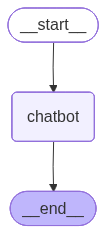

In [19]:
from IPython.display import display,Image
from langgraph.graph import StateGraph,START,END
builder = StateGraph(State)

builder.add_node("chatbot",llm_chatbot)

builder.add_edge(START,"chatbot")
builder.add_edge("chatbot",END)

graph_builder = builder.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [21]:
#invocation
messages=graph_builder.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (rhke3smgj)
 Call ID: rhke3smgj
  Args:
    a: 2
    b: 2


#### To print the output from this Tool , We need to create Tool Node too

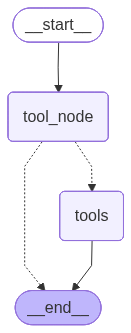

In [23]:
tools = [add]

from langgraph.prebuilt import ToolNode,tools_condition

graph = StateGraph(State)

graph.add_node("tool_node",llm_chatbot)
graph.add_node("tools",ToolNode(tools))

#Add Edge
graph.add_edge(START,"tool_node")
graph.add_conditional_edges("tool_node",tools_condition)
graph.add_edge("tools",END)

graph_builder = graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [25]:
## invocation

messages=graph_builder.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (j6v11f77z)
 Call ID: j6v11f77z
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [27]:
messages=graph_builder.invoke({"messages":"What Machine Learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What Machine Learning
================================== Ai Message ==================================

I don't understand your question. Can you please provide more context or clarify what you are trying to ask?
